In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from chewc.core import *


In [ ]:
#| hide
from chewc.core import *
from chewc.trait import *
from chewc.meiosis import *
from chewc.crossing import *


import torch
import attr
import matplotlib.pyplot as plt


# Chew-C

> Pytorch Breeding

In short, this will be a GPU-enabled stochastic simulation for breeding programs with an emphasis on cost-benefit-analysis for novel breeding tools and creating a suitable interface for RL agents.


---
We will also incorporate an emphasis on budget and costs associated with each action to manage long-term breeding budgets. As well as model theoretical tools in the plant breeder's toolbox. e.g.

> a treatment which increases crossover rates

> a treatment which reduces flowering time

> a treatment which enables gene drive at select loci

Each treatment will cost $$ ultimately helping guide the implementation in real-world breeding programs.


## Install

```sh
pip install chew-c
```

## How to use

First, define the genome of your crop

In [ ]:
#boilerplate example
ploidy = 2
number_chromosomes = 10
loci_per_chromosome = 100
n_founders = 50
genetic_map = create_random_genetic_map(number_chromosomes,loci_per_chromosome)
crop_genome = Genome(ploidy, number_chromosomes, loci_per_chromosome, genetic_map)
founder_pop = create_random_founder_pop(crop_genome , n_founders)

qtl_map = select_qtl_loci(5,crop_genome)
add_fx = generate_marker_effects(qtl_map,0,1)
# Add a trait
trait_A = TraitA(
                qtl_map,
                add_fx,
    genome=crop_genome, 
                 founder_pop=founder_pop, 
                 target_variance=1.0,        # Example: Target genetic variance of 1.0
                 target_mean=10.0)           # Example: Target mean genetic value of 10.0

# Now you can use trait_A to calculate genetic values, simulate phenotypes, etc.
example_genotypes = create_random_founder_pop(crop_genome , 10)  # Example genotypes
genetic_values = trait_A.calculate_genetic_value(example_genotypes)
phenotypes = trait_A.setPheno(example_genotypes, h2=torch.tensor(0.5)) 
print(genetic_values)
print(phenotypes)

tensor([11.7284, 11.6001,  9.7972,  8.4023,  9.8967, 10.0112,  7.7677, 10.5128,
        10.1639, 11.9934])
tensor([10.5428, 11.0402,  9.3920,  7.7007,  9.8136,  9.1105,  7.1924,  9.3808,
         9.9087, 12.1152])


In [ ]:
qtl_map = select_qtl_loci(20, crop_genome)
marker_fx = generate_marker_effects(qtl_map)

founder_genetic_variance = calculate_genetic_variance(founder_pop,marker_fx,crop_genome)


traita = TraitA(qtl_map, marker_fx,crop_genome, founder_pop,1.0,0.0)

In [ ]:
# recurrent truncation selection

means = []
variances = []
traita = TraitA(qtl_map, marker_fx,crop_genome, founder_pop,1.0,0.0)


tgv = traita.calculate_genetic_value(founder_pop)
means.append(tgv.mean())
variances.append(tgv.var())
                 
                 
years = 5

new_pop = random_crosses(founder_pop, len(founder_pop),genetic_map)
tgv = traita.calculate_genetic_value(new_pop)
means.append(tgv.mean())
variances.append(tgv.var())
                 
for i in range(years-1):
    tgv = traita.calculate_genetic_value(new_pop)
    truncate = truncate_select(tgv)
    new_pop = random_crosses(new_pop[truncate], len(new_pop),genetic_map)
    means.append(tgv.mean())
    variances.append(tgv.var())

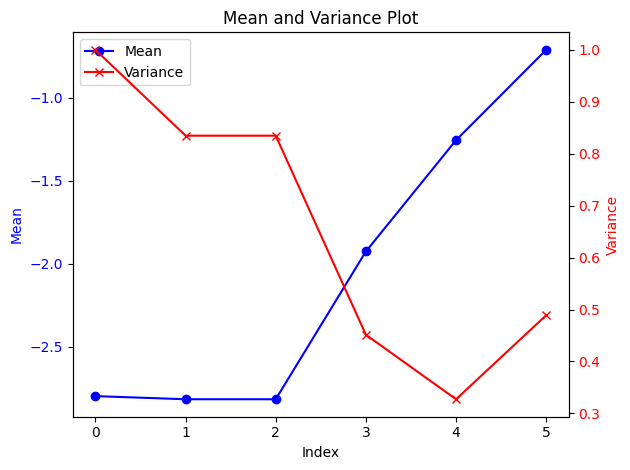

In [ ]:
# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot means
ax1.plot(means, color='blue', marker='o', label='Mean')
ax1.set_xlabel('Index')
ax1.set_ylabel('Mean', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot variances
ax2 = ax1.twinx()
ax2.plot(variances, color='red', marker='x', label='Variance')
ax2.set_ylabel('Variance', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title and show the plot
plt.title('Mean and Variance Plot')
fig.tight_layout()  # Adjust layout to prevent overlap

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.show()